# 4. Difference Image Generation & Analysis

For the Rubin Science Platform at <a href="https://data.lsst.cloud">data.lsst.cloud</a><br>
Data Release: <a href="https://dp1.lsst.io/">Data Preview 1 (DP1)</a> <br>

**Learning Objective:** To analyze the DIA Source Tables produced in Tutorial 3 and create a random forest-based machine learning classifier to evaluate the distinguishing features of injected SL-AGN. 

**LSST Data Products:** `visit_image`, `deep_coadd`

**Packages:** `lsst.daf.butler`, `lsst.rsp`, `lsst.afw.display`, `lsst.source.injection`

**Credit:** This notebook was created by Dhruv Sharma with additional code developed by Shenming Fu (SLAC National Accelerator Laboratory)

## 0. Import Packages & Catalog Files

First, import the necessary methods from `lib/` and any additional packages.

In [2]:
from lib.tools import *
from lib.analysis import *
import matplotlib.pyplot as plt
%matplotlib inline

Also load in some source catalogs from previous notebooks.

In [3]:
diaSources_mark = load_pickle("diaSources_mark")
all_inj_sources = load_pickle("all_inj_sources")
all_dia_sources = load_pickle("all_dia_sources")

## 1. Source Classification

We use the `random_forest` method to distinguish lenses and non-lenses in our DIA Source Tables. This method accepts the many parameters outlined in the columns of `diaSources_mark`, separates the data into a training and testing set, trains on the training set, and evaluates itself on the testing set. 

### 1.1. Random Forest

Run the below code to see how `random_forest` performs on our data.

In [4]:
rf = random_forest(diaSources_mark, diaSources_mark.colnames)

X[:3]: 
 [[ 1.0000000e+00  6.6252851e-01  1.2167453e-01  0.0000000e+00
   2.3809700e-06  4.7755140e-05  1.0827479e-10  0.0000000e+00
   0.0000000e+00  1.6740000e+03  1.8000000e+01  7.5264990e-01
   4.9160305e+01  1.0000000e+00  1.0000000e+00  1.0000000e+00
   1.0000000e+00  1.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  1.0000000e+00  1.0000000e+00
   1.0000000e+00  1.0000000e+00  1.0000000e+00  1.0000000e+00
   1.0000000e+00  1.0000000e+00  1.0000000e+00  1.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00            nan            nan            nan
             nan            nan            nan            nan
             nan            nan            nan            nan

### 1.2. Feature Importances

One of the advantages of `random_forest` based classifiers is that they can evaluate the relative importances of each feature in distinguishing an injected SL-AGN from a non-lens DIA Source. Run the cell below to print the columns, or features, of highest importance, as well as their relative importance.

In [6]:
feat_imp = rf.feature_importances_

sorted_indices = np.argsort(feat_imp)

top_20_indices = sorted_indices[-20:]
for i in range(20):
    print(str(feat_imp[top_20_indices[20-i-1]]) + " - " + str(diaSources_mark.colnames[top_20_indices[20-i-1]]))

## 2. Comparing Features

Let's compare how features correlate and differ between lenses and non-lenses. Run the cell below to generate a *corner-plot*, which plots a few different features against each other in scatterplots, as well as histograms for each feature. Data for lenses is drawn in blue, whereas non-lenses are drawn in red.

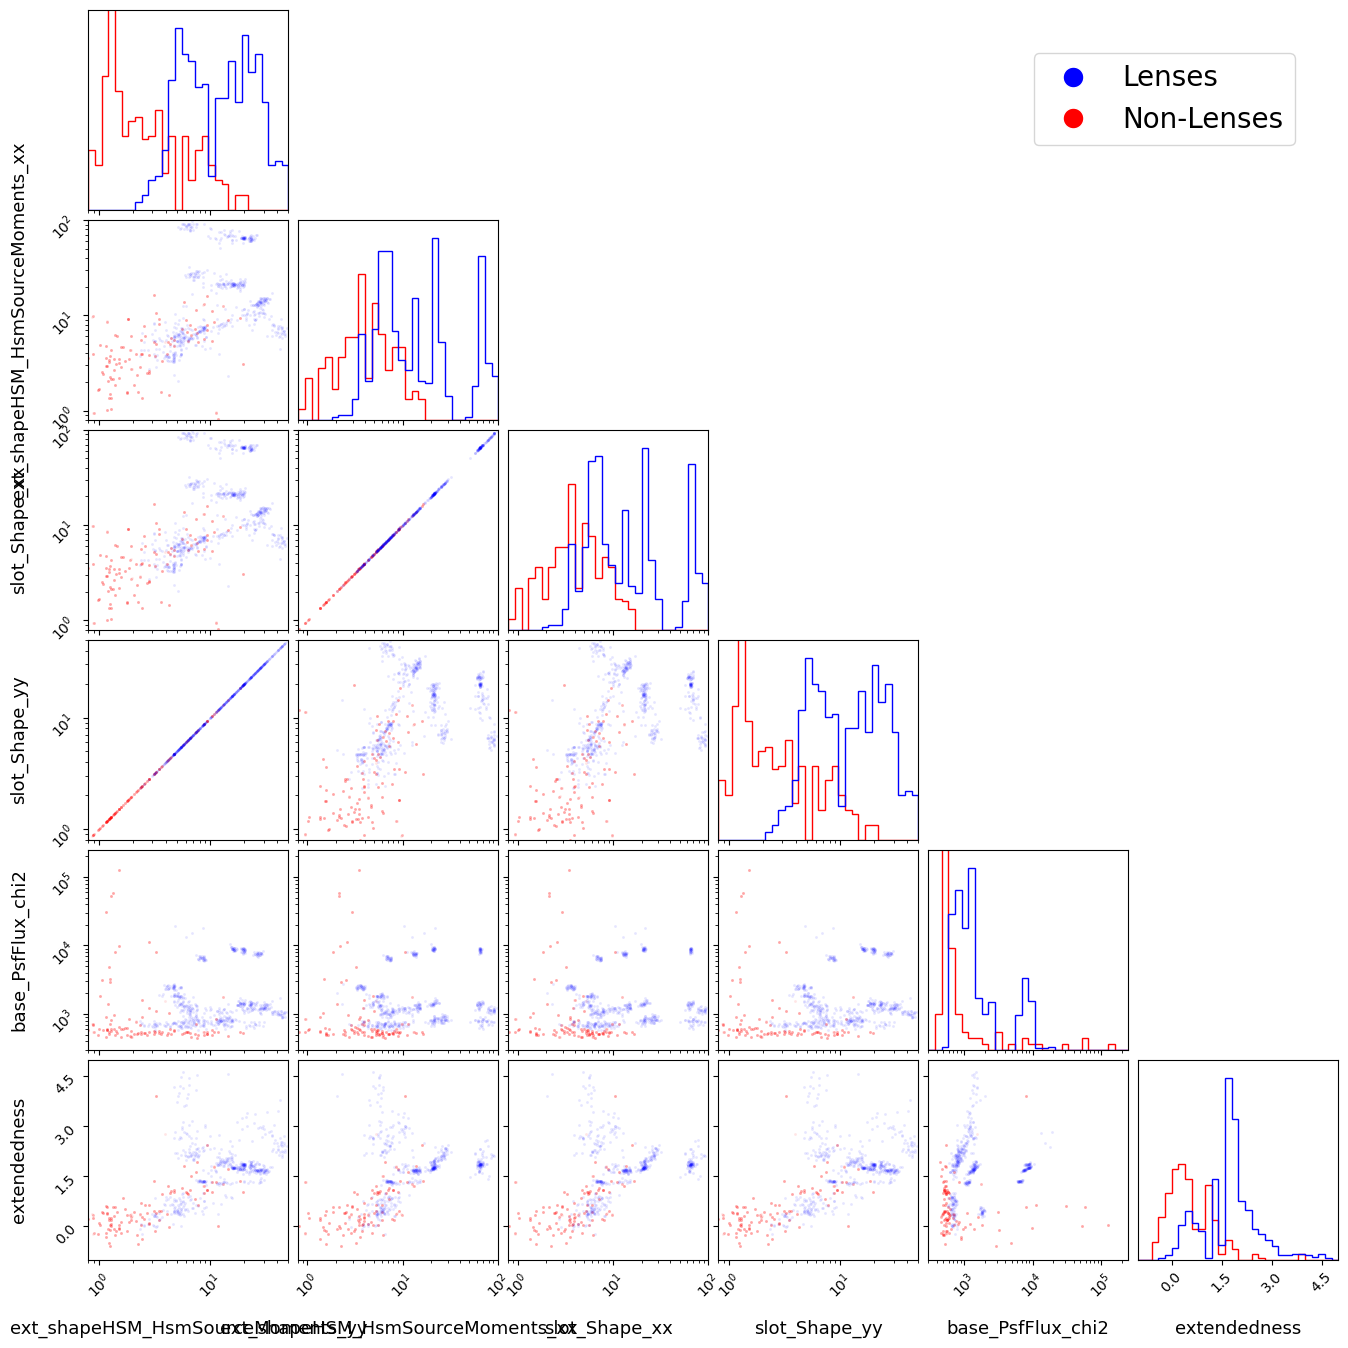

In [8]:
ranges=[(0,50),(0,100),(0,100),(0,0.25),(-50,50)]

import numpy as np
import corner
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

cols = ["ext_shapeHSM_HsmSourceMoments_yy", "ext_shapeHSM_HsmSourceMoments_xx", "slot_Shape_xx", "slot_Shape_yy", "base_PsfFlux_chi2", "extendedness"]  # add more if needed

# Stack data into array
data = np.vstack([diaSources_mark[c] for c in cols]).T

# Make a mask for rows with finite values in all selected columns
mask = np.all(np.isfinite(data), axis=1)

# Apply mask
data = data[mask]
rb_mask = diaSources_mark["RB"][mask]

# Split by RB
data_rb_true = data[rb_mask]
data_rb_false = data[~rb_mask]

labels = cols
ranges = [(0.8,50),(0.8,101),(0.8,100),(0.8,50),(300,0.25e6),(-1,5)]
scales = ["log", "log", "log", "log", "log", "linear"]  

# Plot RB=False first (red)
fig = corner.corner(
    data_rb_false,
    labels=labels,
    label_kwargs={"fontsize": 16},
    color="red",
    bins=30,
    plot_datapoints=True,
    plot_density=False,
    range=ranges,
    plot_contours=False,
    axes_scale=scales,
    hist2d_kwargs={"plot_datapoints": True, "alpha": 1.0}
)

# Overlay RB=True (cyan)
corner.corner(
    data_rb_true,
    labels=labels,
    label_kwargs={"fontsize": 13},
    color="blue",
    bins=30,
    plot_datapoints=True,
    plot_density=False,
    range=ranges,
    plot_contours=False,
    axes_scale=scales,
    fig=fig,
    hist2d_kwargs={"plot_datapoints": True, "alpha": 1.0}
)

custom_lines = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=15, label="Lenses"),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=15, label="Non-Lenses"),
]
fig.legend(handles=custom_lines, loc="upper right", bbox_to_anchor=(0.95, 0.95),fontsize=20)

%matplotlib inline
plt.show()